
### T1 Data Analysis  

        Sean Keenan, PhD Physics  
        Quantum Memories Group, Heriot-Watt University, Edinburgh  
        2021  

In [62]:
import data_funcs as df
from filter_funcs import moving_av, smooth_data
from fit_funcs import exp_decay, find_trigger, fit_exp_decay, fftconvolve
from math_funcs import bin_data, ODset_calc
import matplotlib.pyplot as mp
import numpy as np
import plotting_funcs as plt
import os

mp.style.use('signature.mplstyle')

path = r"c:\Users\sk88\Dropbox (Heriot-Watt University Team)\RES_EPS_Quantum_Photonics_Lab\Experiments\Current Experiments\BB Telecom QM\2023_PrYSO_Coherence\1130_T1\power_1"

In [63]:
folder_list, file_list = df.dir_interogate(path, extensions=('.csv', '.txt'))
T1_file_paths = df.search_paths(folder_list, file_list, include=['.csv'], exclude=['0329_pulse_durations.xlsx'])
T1_info_paths = df.search_paths(folder_list, file_list, include=['.txt'])
excel_data_files = [[df.open_excel(os.path.join(path, x)) for x in file_paths] for file_paths in T1_file_paths]
info_data_files = [df.read_file(os.path.join(path, x))[0][0] for info_paths in T1_info_paths for x in info_paths]


##### Import Data  
        
        Load data sets & extract time and voltage data


In [64]:
time_data_sets = [[excel_file[0] for excel_file in excel_folder] for excel_folder in excel_data_files]
trigger_data_sets = [[excel_file[1] for excel_file in excel_folder] for excel_folder in excel_data_files]
transmitted_data_sets = [[excel_file[2] for excel_file in excel_folder] for excel_folder in excel_data_files]
reference_data_sets = [[excel_file[3] for excel_file in excel_folder] for excel_folder in excel_data_files]
times = [x *1E6 for x in time_data_sets[0][0]]
fluor_duration = [[float(df.find_numbers(row)) for row in text_file if df.check_str(["duration"], row.split())] for text_file in info_data_files] # type: ignore


##### Check channel assignment  

        Plot one of each channel to check assignment is correct for calculations


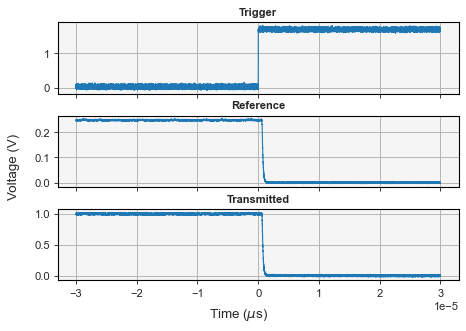

In [65]:
fig, ax = mp.subplots(nrows=3, ncols=1, sharex='all')
# shared labels
fig.tight_layout(w_pad=2, rect=[0.05, 0.05, 1, 1])
fig.supxlabel('Time ($\mu$s)')
fig.supylabel('Voltage (V)')


ax[0].set_title('Trigger')
ax[0].plot(time_data_sets[0][0], trigger_data_sets[0][0])
ax[1].set_title('Reference')
ax[1].plot(time_data_sets[0][0], reference_data_sets[0][0])
ax[2].set_title('Transmitted')
ax[2].plot(time_data_sets[0][0], transmitted_data_sets[0][0])


##### Fine Tune Trigger Point

        Check the trigger index and adjust if neccesary
        

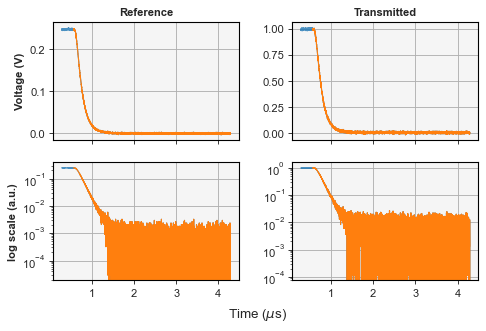

In [69]:
# find the trigger indexes
trig_indexes = [[find_trigger(trigger_data, modifier=0.989) for trigger_data in trigger_list] for trigger_list in trigger_data_sets]
# plot small portion to check ramp off on transmitted data
ramp_off = 5000 + trig_indexes[0][0]
# pick an offset
ref_offset = 350
offset = 350
# plot the transmitted data from trigger point and compare with the offset 
fig, ax = mp.subplots(ncols=2, nrows=2, sharex=True)
# shared labels
fig.tight_layout(w_pad=2, rect=[0, 0.05, 1, 1])
fig.supxlabel('Time ($\mu$s)')
# plot on separate subplots
ax[0][0].set_title('Reference')
ax[0][0].plot(times[trig_indexes[0][0]:ramp_off], reference_data_sets[0][0][trig_indexes[0][0]:ramp_off], label='raw', alpha=0.8)
ax[0][0].plot(times[trig_indexes[0][0]+ref_offset:ramp_off], reference_data_sets[0][0][trig_indexes[0][0]+ref_offset:ramp_off], label='cut')
ax[0][0].set(ylabel='Voltage (V)')

ax[0][1].set_title('Transmitted')
ax[0][1].plot(times[trig_indexes[0][0]:ramp_off], transmitted_data_sets[0][0][trig_indexes[0][0]:ramp_off], label='raw', alpha=0.8)
ax[0][1].plot(times[trig_indexes[0][0]+offset:ramp_off], transmitted_data_sets[0][0][trig_indexes[0][0]+offset:ramp_off], label='cut')

ax[1][0].plot(times[trig_indexes[0][0]:ramp_off], reference_data_sets[0][0][trig_indexes[0][0]:ramp_off], label='raw', alpha=0.8)
ax[1][0].plot(times[trig_indexes[0][0]+ref_offset:ramp_off], reference_data_sets[0][0][trig_indexes[0][0]+ref_offset:ramp_off], label='cut')
ax[1][0].set(ylabel='log scale (a.u.)')
ax[1][0].set_yscale('log')

ax[1][1].plot(times[trig_indexes[0][0]:ramp_off], transmitted_data_sets[0][0][trig_indexes[0][0]:ramp_off], label='raw', alpha=0.8)
ax[1][1].plot(times[trig_indexes[0][0]+offset:ramp_off], transmitted_data_sets[0][0][trig_indexes[0][0]+offset:ramp_off], label='cut')
ax[1][1].set_yscale('log')


##### Process Data  

        Remove negatives and create smoothed and normalised sets


In [70]:
# initial guess for the decay times (us)
guess_ref_T1 = 1E-6
guess_T1 = 2E-6
# shorten data for fitting by finding last index of useful data
ref_stop_indexes = [[round(guess_ref_T1*20 / (time[1] - time[0])) for time in time_lists] for time_lists in time_data_sets]
stop_indexes = [[round(guess_T1*4  / (time[1] - time[0])) for time in time_lists] for time_lists in time_data_sets]
# generate new list of trigger indexes plus the offset
new_trig_indexes = [[value + offset for value in trig_index] for trig_index in trig_indexes]
ref_trig_indexes = [[value + ref_offset for value in trig_index] for trig_index in trig_indexes]
# trim the data sets to only contain data from the trigger onward to the end of useful data index
time_cut_data_sets = [[time[start:start+stop] for time, start, stop in zip(time_set, start_set, stop_set)] for time_set, start_set, stop_set in zip(time_data_sets, new_trig_indexes, stop_indexes)]
ref_cut_time_data_sets = [[ref_time[start:start+stop] for ref_time, start, stop in zip(ref_time_set, start_set, stop_set)] for ref_time_set, start_set, stop_set in zip(time_data_sets, ref_trig_indexes, stop_indexes)]
trans_cut_data_sets = [[trans[start:start+stop] for trans, start, stop in zip(trans_set, start_set, stop_set)] for trans_set, start_set, stop_set in zip(transmitted_data_sets, new_trig_indexes, stop_indexes)]
ref_cut_data_sets = [[ref[start:start+stop] for ref, start, stop in zip(ref_set, start_set, stop_set)] for ref_set, start_set, stop_set in zip(reference_data_sets, ref_trig_indexes, stop_indexes)]
# find max and min values in transmitted data for list comprehension
list_of_mins = [[min(trans_list) for trans_list in transmitted_lists] for transmitted_lists in transmitted_data_sets]
list_of_maxs = [[max(trans_cut_list) for trans_cut_list in trans_cut_lists] for trans_cut_lists in trans_cut_data_sets]
ref_min_list = [[min(ref_list) for ref_list in reference_lists] for reference_lists in reference_data_sets]
ref_max_list = [[max(ref_list) for ref_list in ref_cut_lists] for ref_cut_lists in ref_cut_data_sets]
# create a boxcar window and then create a list of smoothed data
avg_window = moving_av(10)
length_avg_window = avg_window.shape[0] // 2
# create lists of smoothed, corrected, smoothed and corrected
ref_corrected = [[ref_list - min(ref_list) for ref_list in reference_lists] for reference_lists in ref_cut_data_sets]
trans_smoothed = [[fftconvolve(avg_window, trans_cut_list)[length_avg_window-1:-length_avg_window] for trans_cut_list in trans_cut_lists] for trans_cut_lists in trans_cut_data_sets]
trans_corrected = [[trans_list - min(trans_list) for trans_list in transmitted_lists] for transmitted_lists in trans_cut_data_sets]
trans_avg_cor = [[smoothed_list - min(smoothed_list) for smoothed_list in smoothed_lists] for smoothed_lists in trans_smoothed]


##### Fit to Reference Detector Data
        Determine Fall Time

c:\Users\sk88\Documents\Python\Spectroscopy\.spec_venv\Lib\site-packages\scipy\optimize\_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
c:\Users\sk88\Documents\Python\Spectroscopy\fit_funcs.py:58: RuntimeWarning: overflow encountered in exp
  return (y_0 * np.exp(-x/T1)) + offset


Fit Params data[0]:
I0 : 6922778.72 mV, T1 : 0.18 us, Y0 : 3465.18 mV
Fit Error data[0]:
dI0 : 56152.62 mV, dT1 : 0.000 us, dY0 : 36.69 mV 

Fit Params data[1]:
I0 : 19929082.96 mV, T1 : 0.15 us, Y0 : 3730.75 mV
Fit Error data[1]:
dI0 : 117166.12 mV, dT1 : 0.000 us, dY0 : 10.64 mV 

Fit Params data[2]:
I0 : -55470.21 mV, T1 : 0.49 us, Y0 : 3756.51 mV
Fit Error data[2]:
dI0 : 281354.06 mV, dT1 : 0.386 us, dY0 : 11.67 mV 

Fit Params data[3]:
I0 : 1683836.02 mV, T1 : 0.27 us, Y0 : 2715.04 mV
Fit Error data[3]:
dI0 : 17079.35 mV, dT1 : 0.001 us, dY0 : 106.89 mV 

Fit Params data[4]:
I0 : 4766243.74 mV, T1 : 0.20 us, Y0 : 3283.72 mV
Fit Error data[4]:
dI0 : 44561.54 mV, dT1 : 0.001 us, dY0 : 51.15 mV 



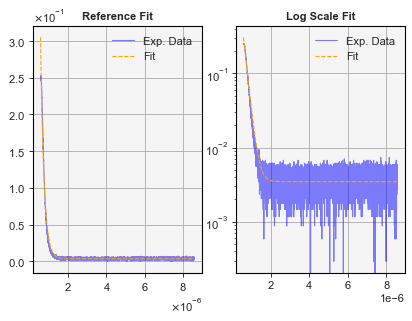

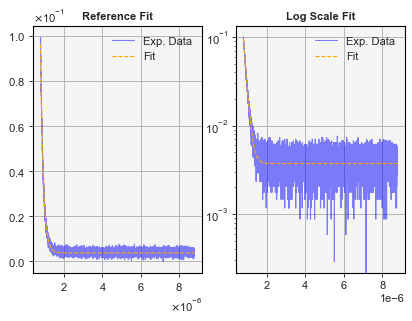

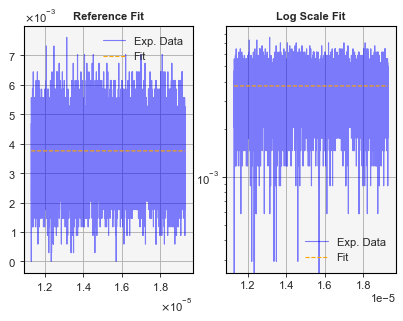

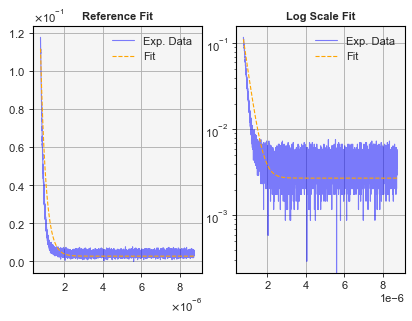

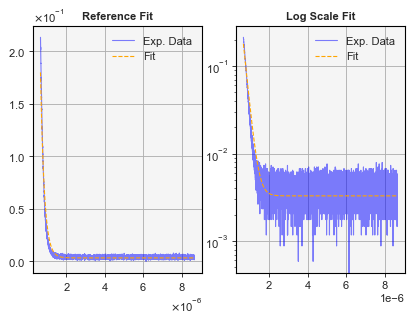

In [71]:
ref_zipped = zip(ref_cut_time_data_sets, ref_corrected, ref_max_list, ref_min_list)
reference_fit_sets = [[fit_exp_decay(time, ref, params=(max_value, guess_ref_T1, min_value)) for time, ref, max_value, min_value in zip(time_set, ref_set, max_set, min_set)] for time_set, ref_set, max_set, min_set in ref_zipped]

# loop over references - fit and plot data of one set per folder
for idx, ref_fitted_set in enumerate(reference_fit_sets):

    fig, ax = mp.subplots(nrows=1, ncols=2)
    
    ax[0].set_title('Reference Fit')
    ax[0].plot(ref_cut_time_data_sets[idx][0], ref_corrected[idx][0], color='blue', alpha=0.5, label='Exp. Data')
    ax[0].plot(ref_cut_time_data_sets[idx][0], exp_decay(np.array(ref_cut_time_data_sets[idx][0]), *ref_fitted_set[idx][0]), color='orange', linestyle='--', alpha=1, label='Fit')
    ax[0].ticklabel_format(axis='both', style='sci', scilimits=(0,0), useMathText = True)
    ax[0].legend()

    ax[1].set_title('Log Scale Fit')
    ax[1].plot(ref_cut_time_data_sets[idx][0], ref_corrected[idx][0], color='blue', alpha=0.5, label='Exp. Data')
    ax[1].plot(ref_cut_time_data_sets[idx][0], exp_decay(np.array(ref_cut_time_data_sets[idx][0]), *ref_fitted_set[idx][0]), color='orange', linestyle='--', alpha=1, label='Fit')
    ax[1].set_yscale('log')
    ax[1].legend()

    # print out fitted values
    print('Fit Params data[{0}]:'.format(idx))
    print("I0 : {0:2.2f} mV, T1 : {1:2.2f} us, Y0 : {2:2.2f} mV".format(*ref_fitted_set[idx][0]*1E6))
    print('Fit Error data[{0}]:'.format(idx))
    print("dI0 : {0:2.2f} mV, dT1 : {1:2.3f} us, dY0 : {2:2.2f} mV \n".format(*ref_fitted_set[idx][1]*1E6))

ref_fall_times = [[T1[0][1] for T1 in reference_fitted] for reference_fitted in reference_fit_sets]


##### Fit To Corrected Data

        Fit to exponential decay and return array of fit params and errors
      

Fit Params data[0]:
I0 : 25213368.58 mV, T1 : 0.19 us, Y0 : 23760.88 mV
Fit Error data[0]:
dI0 : 230518.89 mV, dT1 : 0.000 us, dY0 : 176.42 mV 

Fit Params data[1]:
I0 : 83925143.22 mV, T1 : 0.15 us, Y0 : 23402.06 mV
Fit Error data[1]:
dI0 : 720216.48 mV, dT1 : 0.000 us, dY0 : 66.53 mV 

Fit Params data[2]:
I0 : 3879.80 mV, T1 : 4.00 us, Y0 : 19841.67 mV
Fit Error data[2]:
dI0 : 1087.52 mV, dT1 : 2.202 us, dY0 : 443.42 mV 

Fit Params data[3]:
I0 : 6451798.25 mV, T1 : 0.28 us, Y0 : 16748.07 mV
Fit Error data[3]:
dI0 : 66180.42 mV, dT1 : 0.001 us, dY0 : 448.28 mV 

Fit Params data[4]:
I0 : 17505436.00 mV, T1 : 0.21 us, Y0 : 22848.24 mV
Fit Error data[4]:
dI0 : 175275.93 mV, dT1 : 0.001 us, dY0 : 231.70 mV 



TypeError: only integer scalar arrays can be converted to a scalar index

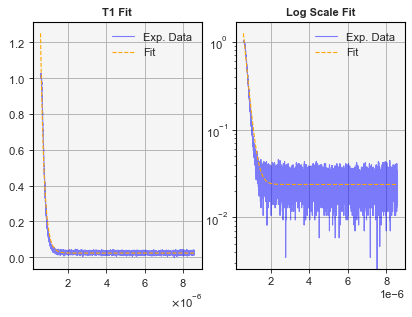

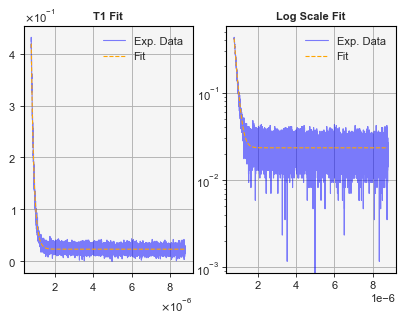

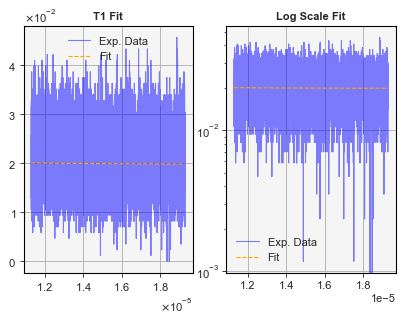

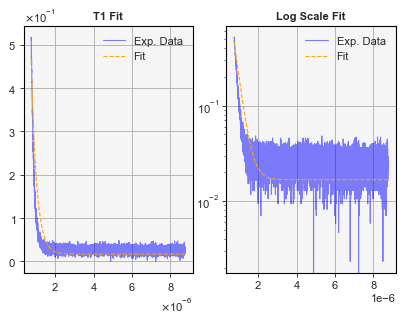

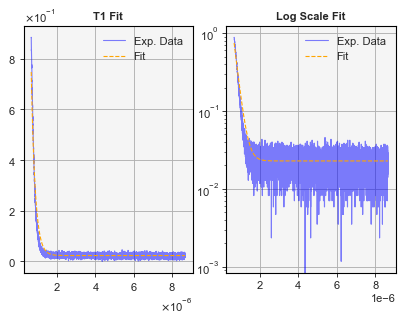

In [72]:
zipped_sgl_data = zip(time_cut_data_sets, trans_corrected, list_of_maxs, list_of_mins)
fit_sgl_sets = [[fit_exp_decay(time, trans, params=(0.3*max_val, guess_T1, min_val)) for time, trans, max_val, min_val in zip(time_set, trans_set, max_set, min_set)] for time_set, trans_set, max_set, min_set in zipped_sgl_data]
fit_data_sets = [[exp_decay(np.array(time), *fit[0]) for time, fit in zip(time_set, fit_set)] for time_set, fit_set in zip(time_cut_data_sets, fit_sgl_sets)]

# loop over references - fit and plot data of one set per folder
for idx, fitted_set in enumerate(fit_sgl_sets):

    fig, ax = mp.subplots(nrows=1, ncols=2)
    
    ax[0].set_title('T1 Fit')
    ax[0].plot(time_cut_data_sets[idx][0], trans_corrected[idx][0], color='blue', alpha=0.5, label='Exp. Data')
    ax[0].plot(time_cut_data_sets[idx][0], exp_decay(np.array(time_cut_data_sets[idx][0]), *fitted_set[idx][0]), color='orange', linestyle='--', alpha=1, label='Fit')
    ax[0].ticklabel_format(axis='both', style='sci', scilimits=(0,0), useMathText = True)
    ax[0].legend()

    ax[1].set_title('Log Scale Fit')
    ax[1].plot(time_cut_data_sets[idx][0], trans_corrected[idx][0], color='blue', alpha=0.5, label='Exp. Data')
    ax[1].plot(time_cut_data_sets[idx][0], exp_decay(np.array(time_cut_data_sets[idx][0]), *fitted_set[idx][0]), color='orange', linestyle='--', alpha=1, label='Fit')
    ax[1].set_yscale('log')
    ax[1].legend()

    # print out fitted values
    print('Fit Params data[{0}]:'.format(idx))
    print("I0 : {0:2.2f} mV, T1 : {1:2.2f} us, Y0 : {2:2.2f} mV".format(*fitted_set[idx][0]*1E6))
    print('Fit Error data[{0}]:'.format(idx))
    print("dI0 : {0:2.2f} mV, dT1 : {1:2.3f} us, dY0 : {2:2.2f} mV \n".format(*fitted_set[idx][-1]*1E6))

T1_times = [[T1[0][1] for T1 in fitted] for fitted in fit_sgl_sets]
T1_binned = [bin_data(T1_set, len(T1_set)//2) for T1_set in T1_times]

In [ ]:
T1_areas = [[simpson(T1_curve, time) for T1_curve, time in zip(T1_fits, times)] for T1_fits, times in zip(fit_data_sets, time_cut_data_sets)]
T1_area_avg = [sf.bin_data(areas, len(areas)//4) for areas in T1_areas]
fluor = [x * 1E6 for sublist in fluor_duration for x in sublist]
mp.plot(fluor, T1_area_avg, 'o')

In [ ]:
count = 0
mp.figure()
for time_set, data_set in zip(time_cut_data_sets, trans_corrected):
    for times, datas in zip(time_set, data_set): 
        area = simpson(datas, times)
        mp.plot(count, area, 'x')
        count += 1

In [ ]:
from scipy.integrate import simpson
#area = 0
count = 0
mp.figure()

for times, datas in zip(time_cut_data_sets[0], trans_corrected[0]): 
    area = simpson(datas, times)
    mp.plot(count, area, 'x')
    count += 1

    


In [ ]:
count = 0
area = []
mp.figure()
for times, datas in zip(time_cut_data_sets[0], trans_corrected[0]): 
    area.append(simpson(datas, times))

mp.hist(area, 8)

In [ ]:
from scipy.integrate import simpson
#area = 0
count = 0


for times, datas in zip(time_cut_data_sets[0], fit_data_sets[0]): 
    area = simpson(datas, times)
    mp.figure()
    mp.plot(times, trans_corrected[0][count])
    mp.plot(times, datas)
    print(area)
    count += 1



##### Fit To Corrected Data

        Fit to double exponential decay and return array of fit params and errors
      

In [ ]:
# zip data together for list comprehension
zipped_data = zip(time_cut_lists, trans_corrected, list_of_maxs, ref_max_list, list_of_mins, ref_fall_times)
fit_corrected = [ff.fit_dbl_exp_decay(time, trans, params=(0.3*max_val, ref_max, guess_T1, min_val, fall_time)) for time, trans, max_val, ref_max, min_val, fall_time in zipped_data]
# loop over corrected transmitted data - fit and plot data
for idx, time in enumerate(time_cut_lists):
    print(idx)

    fig, ax = mp.subplots(nrows=1, ncols=2)
    
    ax[0].set_title('Fluorescence Fit')
    ax[0].plot(time, trans_corrected[idx], color='blue', alpha=0.5, label='Exp. Data')
    ax[0].plot(time, ff.dbl_exp_decay(np.array(time), *fit_corrected[idx][0]), color='orange', linestyle='--', alpha=1, label='Fit')
    ax[0].ticklabel_format(axis='both', style='sci', scilimits=(0,0), useMathText = True)
    ax[0].legend()
    
    ax[1].set_title('Log Scale Fit')
    ax[1].plot(time, trans_corrected[idx], color='blue', alpha=0.5, label='Exp. Data')
    ax[1].plot(time, ff.dbl_exp_decay(np.array(time), *fit_corrected[idx][0]), color='orange', linestyle='--', alpha=1, label='Fit')
    ax[1].set_yscale('log')
    ax[1].legend()
    print('Fit Params data[{0}]:'.format(idx))
    print("I01 : {0:2.2f} mV, I02 : {1:2.2f} mV, T11 : {2:2.2f} us, T12 : {3:2.2f} us, Y0 : {4:2.2f} mV".format(*fit_corrected[idx][0]*1E6))
    print('Fit Error data[{0}]:'.format(idx))
    print("dI01 : {0:2.2f} mV, dI02 : {1:2.2f} mV, dT11 : {2:2.2f} us, dT12 : {3:2.2f} us, dY0 : {4:2.2f} mV \n".format(*fit_corrected[idx][1]*1E6))

In [ ]:
fit_calc = []